In [1]:
import numpy as np
from typing import Tuple, List, Dict, Any
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [2]:


class Sudoku:
    def __init__(self, grid):
        self.grid = np.array(grid)
        self.original_grid = self.grid.copy()
        self.history = []
    
    def is_valid_move(self, row: int, col: int, num: int) -> bool:
        """Verifica si un número es válido en una posición dada"""
        # Verificar fila
        if num in self.grid[row]:
            return False
        
        # Verificar columna
        if num in self.grid[:, col]:
            return False
        
        # Verificar subcuadrícula 3x3
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        if num in self.grid[box_row:box_row+3, box_col:box_col+3]:
            return False
        
        return True
    
    def make_move(self, row: int, col: int, num: int) -> bool:
        """Realiza un movimiento en el tablero"""
        if self.original_grid[row][col] != 0:
            return False
        
        if self.is_valid_move(row, col, num):
            self.grid[row][col] = num
            self.history.append((row, col, num))
            return True
        return False
    
    def undo_move(self, row: int, col: int) -> None:
        """Deshace el último movimiento"""
        if self.original_grid[row][col] == 0:
            self.grid[row][col] = 0
            if self.history:
                self.history.pop()
    
    def get_empty_cell(self) -> Tuple[int, int]:
        """Retorna la primera celda vacía encontrada"""
        for i in range(9):
            for j in range(9):
                if self.grid[i][j] == 0:
                    return i, j
        return None, None
    
    def is_solved(self) -> bool:
        """Verifica si el Sudoku está resuelto"""
        # Verificar que no haya celdas vacías
        if 0 in self.grid:
            return False
        
        # Verificar filas
        for row in self.grid:
            if len(set(row)) != 9:
                return False
        
        # Verificar columnas
        for col in self.grid.T:
            if len(set(col)) != 9:
                return False
        
        # Verificar subcuadrículas 3x3
        for i in range(0, 9, 3):
            for j in range(0, 9, 3):
                subgrid = self.grid[i:i+3, j:j+3].flatten()
                if len(set(subgrid)) != 9:
                    return False
        
        return True
    
    def draw(self):
        """Dibuja el Sudoku usando Matplotlib"""
        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        plt.title("Estado actual del Sudoku", fontsize=14)
        plt.gca().set_facecolor((0.8, 0.8, 0.8))  # Fondo gris claro

        # Dibujar cuadrícula
        for r in range(10):  # 9 + 1 para incluir el borde final
            lw = 2 if r % 3 == 0 else 0.5
            plt.plot([0, 9], [r, r], 'k', linewidth=lw)
            plt.plot([r, r], [0, 9], 'k', linewidth=lw)

        # Añadir números
        for r in range(9):
            for c in range(9):
                if self.grid[r][c] != 0:
                    # Números originales en rojo, los demás en azul
                    color = 'darkred' if self.original_grid[r][c] != 0 else 'darkblue'
                    plt.text(c + 0.5, 8.5 - r, str(self.grid[r][c]),
                            ha='center', va='center', fontsize=14, 
                            color=color, fontweight='bold')

        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.close()

    def get_cell_constraints(self, row: int, col: int) -> int:
        """Calcula el número de restricciones para una celda vacía"""
        if self.grid[row][col] != 0:
            return 0
            
        constraints = 0
        # Contar números en la fila
        constraints += sum(1 for x in self.grid[row] if x != 0)
        # Contar números en la columna
        constraints += sum(1 for x in self.grid[:, col] if x != 0)
        # Contar números en el cuadro 3x3
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        box = self.grid[box_row:box_row+3, box_col:box_col+3]
        constraints += sum(1 for x in box.flatten() if x != 0)
        
        return constraints

    def count_possible_moves(self, row: int, col: int) -> int:
        """Cuenta cuántos números válidos se pueden colocar en una celda"""
        if self.grid[row][col] != 0:
            return 0
            
        count = 0
        for num in range(1, 10):
            if self.is_valid_move(row, col, num):
                count += 1
        return count



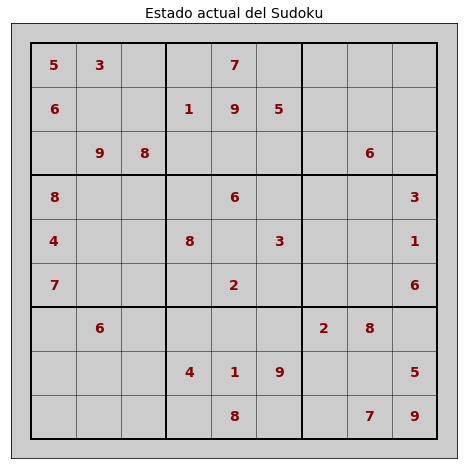

In [3]:
# Tablero de Sudoku inicial (0 representa celdas vacías)
initial_grid = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

# Crear una instancia de la clase Sudoku
sudoku = Sudoku(initial_grid)

# Verificar si el Sudoku está resuelto
print("¿El Sudoku está resuelto?", sudoku.is_solved())

# Dibujar el tablero
sudoku.draw()




In [4]:

class SudokuSolver:
    def __init__(self, sudoku):
        self.sudoku = sudoku
        self.nodes_explored = 0
        self.solution_found = False
        self.time_taken = 0.0
        self.memory_used = 0.0
        self.steps_taken = 0
        self.conflicts = 0
        self.backtracks = 0
        self.heuristic_used = None
    
    def solve(self) -> bool:
        """Método que debe ser sobrescrito por cada solver para resolver el Sudoku"""
        raise NotImplementedError("Este método debe ser sobrescrito por las clases hijas")
    
    def get_solution(self) -> np.ndarray:
        """Retorna la solución encontrada"""
        return self.solution
    
    def get_steps(self) -> list:
        """Retorna los pasos realizados"""
        return self.steps
    
    def get_statistics(self) -> Dict[str, Any]:
        """Método para obtener estadísticas de la solución"""
        return {
            "nodes_explored": self.nodes_explored,
            "solution_found": self.solution_found,
            "time_taken": self.time_taken,
            "memory_used": self.memory_used,
            "steps_taken": self.steps_taken,
            "conflicts": self.conflicts,
            "backtracks": self.backtracks,
            "heuristic_used": self.heuristic_used
        }


In [5]:

class Solver(SudokuSolver):
    def __init__(self, sudoku, max_nodes=10000):
        super().__init__(sudoku)
        self.solution = None
        self.steps = []
        self.max_nodes = max_nodes
        self.moves = []
        self.debug = True
        self.heuristic_used = "Menor número de posibilidades"
    
    def get_next_cell(self) -> Tuple[int, int]:
        """Obtiene la celda vacía con menos posibilidades de movimiento"""
        min_possibilities = float('inf')
        next_cell = None
        
        for i in range(9):
            for j in range(9):
                if self.sudoku.grid[i][j] == 0:
                    possibilities = self.sudoku.count_possible_moves(i, j)
                    if possibilities < min_possibilities:
                        min_possibilities = possibilities
                        next_cell = (i, j)
        
        return next_cell
    
    def solve(self) -> bool:
        """Resuelve el Sudoku usando BFS con heurística de menor número de posibilidades"""
        self.nodes_explored = 0
        self.moves = []
        
        # Obtener la primera celda usando la heurística
        first_cell = self.get_next_cell()
        if first_cell is None:
            return self.sudoku.is_solved()
            
        queue = deque([first_cell])
        
        while queue and self.nodes_explored < self.max_nodes:
            row, col = queue.popleft()
            self.nodes_explored += 1
            
            if self.debug:
                print(f"\nNodo {self.nodes_explored}: Explorando celda ({row}, {col})")
                print(f"Posibilidades en esta celda: {self.sudoku.count_possible_moves(row, col)}")
                if self.moves:
                    print(f"Último movimiento: {self.moves[-1]}")
                print("Estado actual:")
                self.sudoku.draw()
            
            if self.sudoku.grid[row][col] != 0:
                if self.debug:
                    print(f"Celda ({row}, {col}) ya está llena con {self.sudoku.grid[row][col]}")
                next_cell = self.get_next_cell()
                if next_cell is not None:
                    queue.append(next_cell)
                continue
            
            valid_move_found = False
            for num in range(1, 10):
                if self.debug:
                    print(f"Intentando número {num} en ({row}, {col})")
                
                if self.sudoku.is_valid_move(row, col, num):
                    if self.sudoku.make_move(row, col, num):
                        valid_move_found = True
                        self.moves.append((row, col, num))
                        
                        if self.debug:
                            print(f"✓ Número {num} válido en ({row}, {col})")
                        
                        if self.sudoku.is_solved():
                            self.solution_found = True
                            self.solution = self.sudoku.grid.copy()
                            return True
                        
                        next_cell = self.get_next_cell()
                        if next_cell is not None:
                            queue.append(next_cell)
                        break
                    else:
                        if self.debug:
                            print(f"✗ Número {num} no válido en ({row}, {col})")
            
            if not valid_move_found:
                if self.moves:
                    last_row, last_col, last_num = self.moves.pop()
                    self.sudoku.undo_move(last_row, last_col)
                    self.backtracks += 1
                    if self.debug:
                        print(f"↩ Backtrack: Deshaciendo {last_num} en ({last_row}, {last_col})")
                    queue.appendleft((last_row, last_col))
        
        if self.debug:
            print(f"\nSe alcanzó el límite de {self.max_nodes} nodos explorados.")
            print(f"Backtracks realizados: {self.backtracks}")
            print(f"Último estado del tablero:")
            self.sudoku.draw()
        
        return False
    
    def get_solution(self) -> np.ndarray:
        """Retorna la solución encontrada"""
        return self.solution
    
    def get_steps(self) -> list:
        """Retorna los pasos realizados"""
        return self.moves


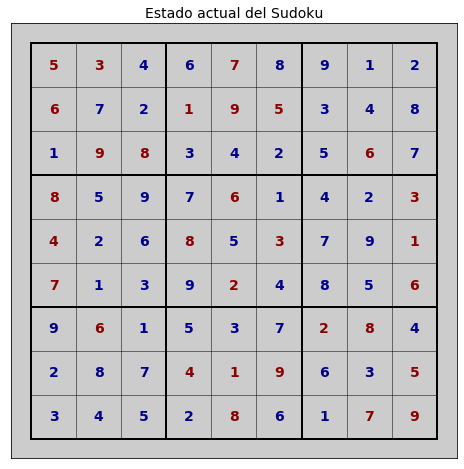

In [6]:
# Crear un Sudoku
sudoku = Sudoku(initial_grid)
sudoku.draw();

# Crear el solver
solver = Solver(sudoku, max_nodes=100_00000_000)

# Resolver el Sudoku
if solver.solve():
    print("¡Sudoku resuelto!")
    print(f"Nodos explorados: {solver.get_statistics()['nodes_explored']}")
    sudoku.grid = solver.get_solution()
    sudoku.draw()
else:
    print("No se encontró solución")